In [2]:
%matplotlib inline
import os
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10,5)

In [5]:
# Loader: accepts a single JSONL file or a directory of .jsonl files
# Change data_path to './dataset/all_data.jsonl' if you prefer a single file
data_path = r'C:\Users\Pasindu Gunarathne\Downloads\sinXdetect\ml\dataset\dataset.jsonl'
dfs = []
if os.path.isfile(data_path):
    df = pd.read_json(data_path, lines=True)
    dfs.append(df)
    print(f'Loaded {len(df)} rows from {data_path}')
elif os.path.isdir(data_path):
    for fn in sorted(os.listdir(data_path)):
        if fn.endswith('.jsonl'):
            path = os.path.join(data_path, fn)
            try:
                df = pd.read_json(path, lines=True)
                dfs.append(df)
                print(f'Loaded {len(df)} rows from {fn}')
            except Exception as e:
                print('Failed to read', path, e)
else:
    raise FileNotFoundError(f'No file or directory found at {data_path}')
if not dfs:
    raise FileNotFoundError('No .jsonl files found in dataset path')
data = pd.concat(dfs, ignore_index=True)
print('Dataframe shape:', data.shape)
display(data.head())

Loaded 90457 rows from C:\Users\Pasindu Gunarathne\Downloads\sinXdetect\ml\dataset\dataset.jsonl
Dataframe shape: (90457, 3)


,text,label,meta
0,මත්ද්‍රව්‍ය ජාවාරමකට සම්බන්ධ පුද්ගලයෙකු පොලිස්...,AI,"{'source': 'www.lankadeepa.lk', 'url': 'https:..."
1,ශ්‍රී ලංකාවේ නව කැබිනට් මණ්ඩලයේ සංශෝධනය පිළිබඳ...,AI,"{'source': 'www.lankadeepa.lk', 'url': 'https:..."
2,2012 පෙබරවාරි මාසයේ වැල්ලම්පිටියේ දී යුද හමුදා...,HUMAN,"{'source': 'www.lankadeepa.lk', 'url': 'https:..."
3,(මනෝප්‍රිය ගුණසේකර)කතෝලික දේවස්ථාන හා තරුපහේ හ...,HUMAN,"{'source': 'www.lankadeepa.lk', 'url': 'https:..."
4,මැතිවරණ කොමිසම වෙත මැතිවරණ ආශ්‍රිත පැමිණිලි 45...,AI,"{'source': 'www.lankadeepa.lk', 'url': 'https:..."


In [6]:
# Basic info and checks
print(data.info())
print('Columns:', list(data.columns))
if 'text' not in data.columns or 'label' not in data.columns:
    raise ValueError('Expected columns `text` and `label` in the dataset')
data['label'] = data['label'].astype(str)
print('Label counts:')
print(data['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90457 entries, 0 to 90456
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    90457 non-null  object
 1   label   90457 non-null  object
 2   meta    90457 non-null  object
dtypes: object(3)
memory usage: 2.1+ MB
None
Columns: ['text', 'label', 'meta']
Label counts:
HUMAN    49811
AI       40646
Name: label, dtype: int64


C:\Users\PASIND~1\AppData\Local\Temp/ipykernel_9604/3552219099.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=data, order=data['label'].value_counts().index, palette='muted')


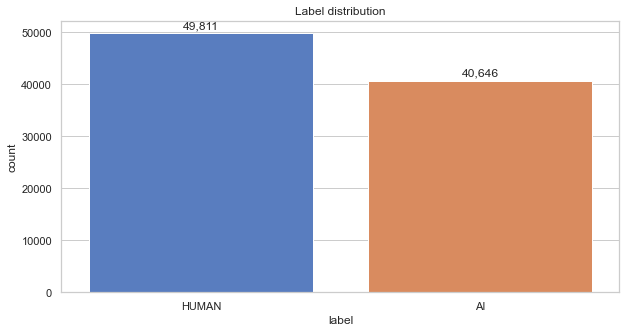

In [7]:
# Plot label distribution
ax = sns.countplot(x='label', data=data, order=data['label'].value_counts().index, palette='muted')
ax.set_title('Label distribution')
for p in ax.patches:
    ax.annotate(format(int(p.get_height()), ','), (p.get_x()+p.get_width()/2., p.get_height()),
                ha='center', va='center', xytext=(0, 8), textcoords='offset points')
plt.show()

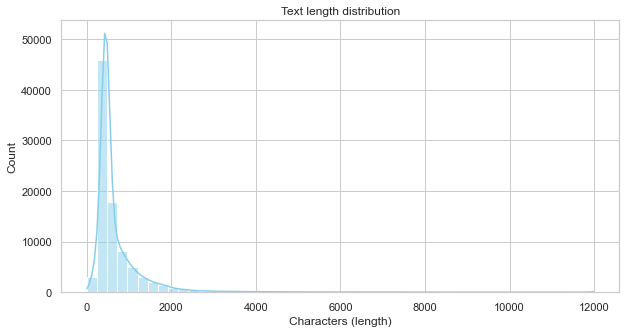

In [8]:
# Text length distribution
data['text_len'] = data['text'].astype(str).map(len)
sns.histplot(data=data, x='text_len', bins=50, kde=True, color='skyblue')
plt.title('Text length distribution')
plt.xlabel('Characters (length)')
plt.show()

In [9]:
# Simple preprocessing used for EDA (keeps Sinhala range, digits, ascii letters, basic punctuation)
import re
pattern = re.compile(r"[^\u0D80-\u0DFF0-9A-Za-z\.,;:!\?\(\)\"'\-\/\s]")
def preprocess_for_eda(text):
    if not isinstance(text, str):
        return ''
    text = text.replace('\u200d', '')
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = pattern.sub(' ', text)
    return re.sub(r'\s+', ' ', text).strip()

data['text_clean'] = data['text'].map(preprocess_for_eda)
data[['text', 'text_clean']].head()

,text,text_clean
0,මත්ද්‍රව්‍ය ජාවාරමකට සම්බන්ධ පුද්ගලයෙකු පොලිස්...,මත්ද්රව්ය ජාවාරමකට සම්බන්ධ පුද්ගලයෙකු පොලිස් අ...
1,ශ්‍රී ලංකාවේ නව කැබිනට් මණ්ඩලයේ සංශෝධනය පිළිබඳ...,ශ්රී ලංකාවේ නව කැබිනට් මණ්ඩලයේ සංශෝධනය පිළිබඳ ...
2,2012 පෙබරවාරි මාසයේ වැල්ලම්පිටියේ දී යුද හමුදා...,2012 පෙබරවාරි මාසයේ වැල්ලම්පිටියේ දී යුද හමුදා...
3,(මනෝප්‍රිය ගුණසේකර)කතෝලික දේවස්ථාන හා තරුපහේ හ...,(මනෝප්රිය ගුණසේකර)කතෝලික දේවස්ථාන හා තරුපහේ හෝ...
4,මැතිවරණ කොමිසම වෙත මැතිවරණ ආශ්‍රිත පැමිණිලි 45...,මැතිවරණ කොමිසම වෙත මැතිවරණ ආශ්රිත පැමිණිලි 450...


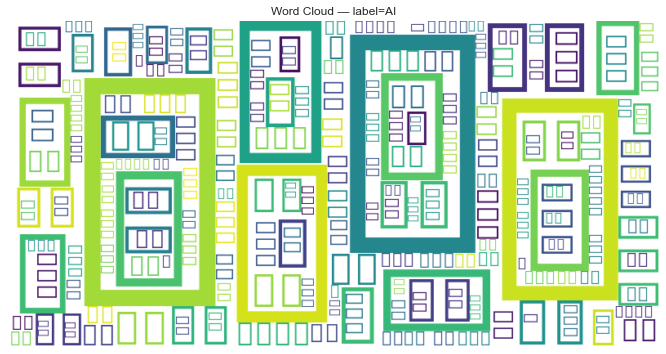

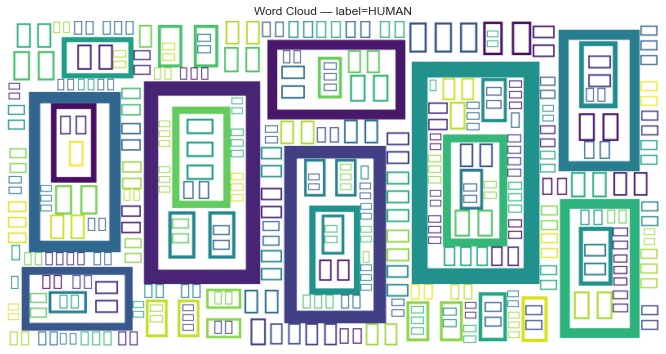

In [10]:
# Word clouds per label (skip if very large)
labels = data['label'].unique()
for label in labels:
    subset = data[data['label'] == label]
    text_blob = ' '.join(subset['text_clean'].dropna().astype(str).values.tolist())
    if len(text_blob) < 10:
        print(f'Label {label} has too little text for a wordcloud, skipping')
        continue
    wc = WordCloud(width=800, height=400, background_color='white', collocations=False, max_words=200).generate(text_blob)
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud — label={label}')
    plt.show()

In [11]:
# Top N-word and char n-grams per label
def top_ngrams(corpus, ngram_range=(1,1), top_k=20):
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_k]

for label in labels:
    subset = data[data['label']==label]['text_clean'].astype(str).values
    print('\nTop word unigrams for label=', label)
    for w, c in top_ngrams(subset, ngram_range=(1,1), top_k=15):
        print(w, int(c))
    print('\nTop char 3-grams for label=', label)
    for w, c in top_ngrams(subset, ngram_range=(3,3), top_k=15):
        print(w, int(c))


Top word unigrams for label= AI
ඇත 120513
සම 55297
කර 54505
බව 49065
බන 44837
මට 44819
වන 40855
ධය 39370
අතර 37707
රත 35119
වය 26342
පර 25173
වට 25008
රක 23758
සහ 21910

Top char 3-grams for label= AI
ඇත 120513
සම 55297
කර 54505
බව 49065
බන 44837
මට 44819
වන 40855
ධය 39370
අතර 37707
රත 35119
වය 26342
පර 25173
වට 25008
රක 23758
සහ 21910

Top char 3-grams for label= AI
සම බන ධය 38600
අත අඩ වට 13484
ආරම කර ඇත 9439
කර ඇත අතර 7597
මට යම තය 6305
ධය තවද රටත 5974
බන ධය තවද 5969
බන ධය පර 5472
බන ධය මර 4568
ධය පර ෂණ 4499
පර ෂණ ආරම 4462
ෂණ ආරම කර 4343
ඇත සම බන 4336
පර ෂණ පවත 4254
ධය මර ශන 4150

Top word unigrams for label= HUMAN
සම බන ධය 38600
අත අඩ වට 13484
ආරම කර ඇත 9439
කර ඇත අතර 7597
මට යම තය 6305
ධය තවද රටත 5974
බන ධය තවද 5969
බන ධය පර 5472
බන ධය මර 4568
ධය පර ෂණ 4499
පර ෂණ ආරම 4462
ෂණ ආරම කර 4343
ඇත සම බන 4336
පර ෂණ පවත 4254
ධය මර ශන 4150

Top word unigrams for label= HUMAN
ඇත 121817
වන 97880
කර 84804
පත 77951
මට 74385
කළ 65591
බව 61258
මහත 60591
යන 59229
සම 56310
සහ 52754
යක 50635
වට 4857

In [ ]:
# Save a small sample for manual inspection
sample_out = 'eda_sample.csv'
data.sample(min(1000, len(data))).to_csv(sample_out, index=False)
print(f'Saved sample to {sample_out}')

**Notes & next steps**
- For token-level statistics or better Sinhala tokenization, consider using `sentencepiece` or a language-specific tokenizer.
- For very large datasets, sample before generating wordclouds or n-grams to reduce memory use.
- I can extend this notebook to export a features CSV (TF-IDF) or run quick baseline models if you want.